In [2]:
import json
from keras.utils import np_utils
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import sys
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Bidirectional, Dense, Embedding, SimpleRNN, LSTM
from tensorflow.keras.utils import plot_model



In [3]:
audio_folder = '/Users/lindawong/Desktop/github/Youtube-Video-Popularity-Prediction/processed_audio_0'
audio_df = pd.read_csv('/Users/lindawong/Desktop/github/Youtube-Video-Popularity-Prediction/audio_analysis/rating.csv')

audio_ids = pd.read_json('/Users/lindawong/Desktop/github/Youtube-Video-Popularity-Prediction/Models/Audio Modality/video_ids_balanced.json')
audio_ids = audio_ids.to_numpy().squeeze()
audio_ids = [aid[:-4] for aid in audio_ids]

audio_df = audio_df[audio_df['video_id'].isin(audio_ids)]
audio_ratings = audio_df['rating'].to_numpy()

num_audio = len(audio_ids)
max_frames = 800
num_features = 25

# construct audio data matrix of shape (number of audio clips, number of frames, number of features)
audio_data = np.zeros((num_audio, max_frames, num_features))
for i, aid in enumerate(audio_ids):
    file = 'audio_' + aid + '.csv'
    data = pd.read_csv(os.path.join(audio_folder, file), index_col=0).to_numpy()
    
    num_frames = data.shape[0]
    if data.shape[0] < max_frames:
        audio_data[i,:num_frames,:] = data
    else:
        audio_data[i,:,:] = data[:800,:]
        
print(audio_data.shape)

(961, 800, 25)


(-0.002, 0.1]    100
(0.1, 0.2]       100
(0.2, 0.3]       100
(0.3, 0.4]       100
(0.4, 0.5]       100
(0.5, 0.6]       100
(0.6, 0.7]       100
(0.7, 0.8]        98
(0.8, 0.9]        74
(0.9, 1.0]        89
dtype: int64


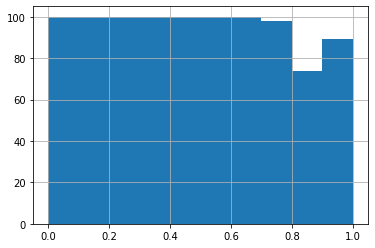

In [4]:
# analyze distribution of ratings
rating = pd.Series(audio_ratings)
print(rating.value_counts(bins=10).sort_index())
rating.hist(bins=10)

In [5]:
# balance dataset
"""
balanced_df = pd.DataFrame(columns=audio_df.columns)
for j in range(10):
    temp_df = pd.DataFrame()
    lower = j/10
    upper = (j+1)/10 if j < 9 else 1.1
    temp_data = audio_df[(audio_df['rating'] >= lower) & (audio_df['rating'] < upper)]
    temp_data = temp_data.sample(frac=1)
    if temp_data.shape[0] > 100:
        temp_data = temp_data.head(100)
    balanced_df = balanced_df.append(temp_data)

b_audio_ratings = balanced_df['rating']
rating = pd.Series(b_audio_ratings)
print(rating.value_counts(bins=10).sort_index())
rating.hist(bins=10)

b_audio_ids = balanced_df['video_id']
num_b_audio = len(b_audio_ids)
max_frames = 800
num_features = 25

b_audio_data = np.zeros((num_b_audio, max_frames, num_features))
for i, aid in enumerate(b_audio_ids):
    file = 'audio_' + aid + '.csv'
    data = pd.read_csv(os.path.join(audio_folder, file), index_col=0).to_numpy()
    
    num_frames = data.shape[0]
    if data.shape[0] < max_frames:
        b_audio_data[i,:num_frames,:] = data
    else:
        b_audio_data[i,:,:] = data[:800,:]
        
print(b_audio_data.shape)
"""

"\nbalanced_df = pd.DataFrame(columns=audio_df.columns)\nfor j in range(10):\n    temp_df = pd.DataFrame()\n    lower = j/10\n    upper = (j+1)/10 if j < 9 else 1.1\n    temp_data = audio_df[(audio_df['rating'] >= lower) & (audio_df['rating'] < upper)]\n    temp_data = temp_data.sample(frac=1)\n    if temp_data.shape[0] > 100:\n        temp_data = temp_data.head(100)\n    balanced_df = balanced_df.append(temp_data)\n\nb_audio_ratings = balanced_df['rating']\nrating = pd.Series(b_audio_ratings)\nprint(rating.value_counts(bins=10).sort_index())\nrating.hist(bins=10)\n\nb_audio_ids = balanced_df['video_id']\nnum_b_audio = len(b_audio_ids)\nmax_frames = 800\nnum_features = 25\n\nb_audio_data = np.zeros((num_b_audio, max_frames, num_features))\nfor i, aid in enumerate(b_audio_ids):\n    file = 'audio_' + aid + '.csv'\n    data = pd.read_csv(os.path.join(audio_folder, file), index_col=0).to_numpy()\n    \n    num_frames = data.shape[0]\n    if data.shape[0] < max_frames:\n        b_audio_dat

In [29]:
d = audio_data.copy()
d = d.reshape((d.shape[0]*d.shape[1], d.shape[2]))
d = d[:,:13]

df = pd.DataFrame(d, columns=[str(i) for i in range(13)])
df.to_csv('audio_data.csv', index=False)

(768800, 13)


In [15]:
# implementation of LSTM model
class LSTMModel:
    def __init__(self, data, labels, num_audio, max_frames, num_features):
        self.data = data
        self.labels = labels
        self.num_audio = num_audio
        self.max_frames = max_frames
        self.num_features = num_features
        self.batch_size = 64
        self.lstm_dim = 100
        self.model = None
        self.train_data = None
        self.test_data = None
        self.train_labels = None
        self.test_labels = None
        
    def prepare_data(self, labels):
        
        # divide into train and test sets
        self.train_data, self.test_data, self.train_labels, self.test_labels = \
            train_test_split(self.data, labels, test_size=0.3)

        num_train, num_test = self.train_data.shape[0], self.test_data.shape[0]
        
        # apply z-score normalization
        scaler = preprocessing.StandardScaler()
        
        self.train_data = self.train_data.reshape((num_train*self.max_frames, self.num_features))
        self.train_data = scaler.fit_transform(self.train_data)
        self.train_data = self.train_data.reshape((num_train, self.max_frames, self.num_features))
        
        self.test_data = self.test_data.reshape((num_test*self.max_frames, self.num_features))
        self.test_data = scaler.transform(self.test_data)
        self.test_data = self.test_data.reshape((num_test, self.max_frames, self.num_features))
        
        print("Train data size: ", self.train_data.shape, self.train_labels.shape)
        print("Test data size: ", self.test_data.shape, self.test_labels.shape)
        
    def build_regression_model(self):
        print("Building model ...")
        # construct regression model
        self.model = Sequential()
        self.model.add(Dense(self.batch_size, input_shape=(self.max_frames, self.num_features)))
        self.model.add(Dense(300, activation='relu'))
        self.model.add(Dense(150, activation='relu'))
        self.model.add(LSTM(self.lstm_dim, return_sequences=False))
        self.model.add(Dense(1, activation='linear'))

        self.model.compile(loss='mse', optimizer='adam', metrics=['mse'])
        
        print(self.model.summary())
        plot_model(self.model, 'audio_regression_model.png', show_shapes=True)
        
    def train_regression_model(self):
        
        self.prepare_data(self.labels)

        i = self.num_audio // self.batch_size
        i *= self.batch_size
        self.train_data = self.train_data[:i,:,:]
        self.train_labels = self.train_labels[:i]

        print("Training model ...")
        self.model.fit(self.train_data, self.train_labels, 
                  batch_size=self.batch_size, shuffle=True, epochs=7)
        
    def test_regression_model(self):
        print("Predicting ...")
        self.model.evaluate(self.test_data, self.test_labels)
        pred = self.model.predict(self.test_data)
        pred = pred.squeeze()
        self.test_labels = self.test_labels.tolist()
        

        error = [p-t for p, t in zip(pred, self.test_labels)]

        error = pd.Series(error)
        print(error.value_counts(bins=10).sort_index())
        error.hist(bins=10)
        
        """
        sns.distplot(error, hist=False, rug=True, axlabel='error')
        plt.show()
        """
        
    def build_classification_model(self):
        print("Building model ...")
        # construct classification model
        self.model = Sequential()
        self.model.add(Dense(self.batch_size, input_shape=(self.max_frames, self.num_features)))
        self.model.add(Dense(300, activation='relu'))
        self.model.add(Dense(150, activation='relu'))
        self.model.add(LSTM(self.lstm_dim, return_sequences=False))
        self.model.add(Dense(1, activation='sigmoid'))

        self.model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
        
        print(self.model.summary())
        plot_model(self.model, 'audio_classification_model.png', show_shapes=True)
        
    def train_classification_model(self):
        # convert labels to 0 and 1
        # 0 = not useful, 1 = useful
        binary_labels = []
        for l in self.labels:
            if l < 0.5:
                binary_labels.append(0)
            else:
                binary_labels.append(1)
        encoder = LabelEncoder()
        encoder.fit(binary_labels)
        labels = encoder.transform(binary_labels)

        self.prepare_data(labels)

        i = self.num_audio // self.batch_size
        i *= self.batch_size
        self.train_data = self.train_data[:i,:,:]
        self.train_labels = self.train_labels[:i]

        print("Training model ...")
        self.model.fit(self.train_data, self.train_labels, 
                  batch_size=self.batch_size, shuffle=True, epochs=7)
        
    def test_classification_model(self):
        print("Predicting ...")
        self.model.evaluate(self.test_data, self.test_labels)
        pred = self.model.predict(self.test_data)
        pred[pred < 0.5] = 0
        pred[pred >= 0.5] = 1
        
        print(classification_report(self.test_labels, pred)) 

Building model ...
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 800, 64)           896       
_________________________________________________________________
dense_13 (Dense)             (None, 800, 300)          19500     
_________________________________________________________________
dense_14 (Dense)             (None, 800, 150)          45150     
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               100400    
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 101       
Total params: 166,047
Trainable params: 166,047
Non-trainable params: 0
_________________________________________________________________
None
Train data size:  (672, 800, 13) (672,)
Test data size:  (289, 800, 13) (289,)
Training mo

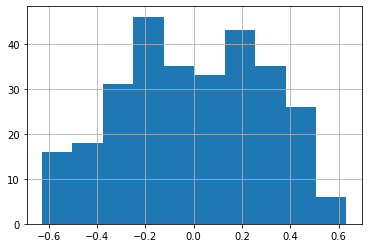

In [16]:
mfcc_data = audio_data[:,:,:13]
num_features = 13
audio_model = LSTMModel(mfcc_data, audio_ratings, num_audio, max_frames, num_features)
audio_model.build_regression_model()
audio_model.train_regression_model()
audio_model.test_regression_model()

In [27]:
mfcc_data = audio_data[:,:,:13]
num_features = 13
audio_model = LSTMModel(mfcc_data, audio_ratings, num_audio, max_frames, num_features)
audio_model.build_classification_model()
audio_model.train_classification_model()
audio_model.test_classification_model()

Building model ...
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 800, 64)           896       
_________________________________________________________________
dense_21 (Dense)             (None, 800, 300)          19500     
_________________________________________________________________
dense_22 (Dense)             (None, 800, 150)          45150     
_________________________________________________________________
lstm_5 (LSTM)                (None, 100)               100400    
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 101       
Total params: 166,047
Trainable params: 166,047
Non-trainable params: 0
_________________________________________________________________
None
Train data size:  (672, 800, 13) (672,)
Test data size:  (289, 800, 13) (289,)
Training mo

KeyboardInterrupt: 